In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Splits data into train and test sets

def train_test_split(class_data):
    split_ratio=0.8

    class_data = np.array(class_data)
    
    # Extract features and labels
    features = class_data[:, :-1]
    labels = class_data[:, -1]
    
    unique_classes = np.unique(labels)
    
    train_data = []
    test_data = []
    
    for cls in unique_classes:
        cls_indices = np.where(labels == cls)[0]
        np.random.shuffle(cls_indices)
        split_index = int(len(cls_indices) * split_ratio)
        train_indices = cls_indices[:split_index]
        test_indices = cls_indices[split_index:]
        train_data.extend(class_data[train_indices])
        test_data.extend(class_data[test_indices])
    
    train_data = np.array(train_data)
    test_data = np.array(test_data)
    
    np.random.shuffle(train_data)
    np.random.shuffle(test_data)
    
    return train_data, test_data

# Splits data by class labels
def class_split(data):
    features = data[:, :-1].astype(float)
    labels = data[:, -1].astype(int)
    return features, labels

def calculate_feature_statistics(feature_data, class_labels):
    stats = {}
    unique_labels = np.unique(class_labels)
    for label in unique_labels:
        class_data = feature_data[class_labels == label].astype(float)
        stats[label] = {
            'mean': np.mean(class_data, axis=0),
            'std': np.sqrt(np.var(class_data, axis=0)),
            'prior': len(class_data) / len(feature_data)
        }
    return stats


def gaussian_probability_density_function(x, mean, std):
    x = np.array(x)
    mean = np.array(mean)
    std = np.array(std)
    exponent = np.exp(-((x - mean) ** 2 / (2 * std ** 2)))
    return (1 / (np.sqrt(2 * np.pi) * std)) * exponent



def naive_bayes_prediction(feature_stats, data_point):
    probabilities = {}
    total_probability = 0
    
    for class_label, stats in feature_stats.items():
        log_likelihood = 0
        for i, feature_value in enumerate(data_point):
            mean = stats['mean'][i]
            std_dev = stats['std'][i]
            log_likelihood += np.log(gaussian_probability_density_function(feature_value, mean, std_dev))
        log_prior = np.log(stats['prior'])
        probabilities[class_label] = np.exp(log_likelihood + log_prior)
        total_probability += probabilities[class_label]
    
    # Normalize probabilities
    for class_label in probabilities:
        probabilities[class_label] /= total_probability
    
    return probabilities


# Convert probabilities to final class prediction
def probabilities_to_prediction(probabilities):
    class_prediction = max(probabilities, key=probabilities.get)
    return class_prediction

# Calculate TPR and FPR at different thresholds

# Calculate TPR and FPR at different thresholds
# Calculate TPR and FPR at different thresholds
def TPR_and_FPR(prediction_probabilities, test_labels, threshold_stepsize=0.1):
    thresholds = np.arange(0, 1 + threshold_stepsize, threshold_stepsize)
    TPR, FPR = [], []
    test_labels = np.array(test_labels)
    
    for threshold in thresholds:
        predicted = (np.array(prediction_probabilities) >= threshold).astype(int)

        TP = np.sum((predicted == 1) & (test_labels == 1))
        FP = np.sum((predicted == 1) & (test_labels == 0))
        FN = np.sum((predicted == 0) & (test_labels == 1))
        TN = np.sum((predicted == 0) & (test_labels == 0))

        TPR_value = TP / (TP + FN) if (TP + FN) > 0 else 0
        FPR_value = FP / (FP + TN) if (FP + TN) > 0 else 0
        TPR.append(TPR_value)
        FPR.append(FPR_value)

    return TPR, FPR


# Plot ROC curve
def plot_ROC(TPR, FPR, class_1, class_2):
    auc_score = np.trapz(sorted(TPR), sorted(FPR))
    plt.plot(FPR, TPR, color='b', label=f"AUC = {auc_score:.3f}")
    plt.plot([0, 1], [0, 1], linestyle='dashdot', color='r', label='Random Guess')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve: {class_1} vs. {class_2}")
    plt.legend()
    plt.show()


# Cross-validation with ROC analysis
def cross_validation(data, target, folds=10, threshold_stepsize=0.1):
    fold_size = len(data) // folds
    unique_classes = np.unique(target)
    if len(unique_classes) != 2:
        raise ValueError("ROC analysis requires exactly two classes.")
    
    class_1, class_2 = unique_classes[1], unique_classes[0]
    all_TPR, all_FPR = [], []
    
    for i in range(folds):
        # Create train-test splits
        start, end = i * fold_size, (i + 1) * fold_size
        test_data = data[start:end]
        test_labels = target[start:end]
        train_data = np.concatenate((data[:start], data[end:]), axis=0)
        train_labels = np.concatenate((target[:start], target[end:]), axis=0)
        
        # Train Naive Bayes and predict probabilities
        feature_stats = calculate_feature_statistics(train_data, train_labels)
        prediction_probabilities = [
            naive_bayes_prediction(feature_stats, x)[class_1] for x in test_data
        ]
        
        # Calculate TPR and FPR
        TPR, FPR = TPR_and_FPR(prediction_probabilities, test_labels, threshold_stepsize)
        all_TPR.append(TPR)
        all_FPR.append(FPR)
    
    # Average TPR and FPR across folds
    mean_TPR = np.mean(all_TPR, axis=0)
    mean_FPR = np.mean(all_FPR, axis=0)
    
    # Plot ROC
    plot_ROC(mean_TPR, mean_FPR, class_1, class_2)



[[0, 'Iris-setosa'], [1, 'Iris-versicolor'], [2, 'Iris-virginica']]
[0, 1, 2]
True labels: [2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2]
Predictions: [2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2]
Accuracy: 100.00%


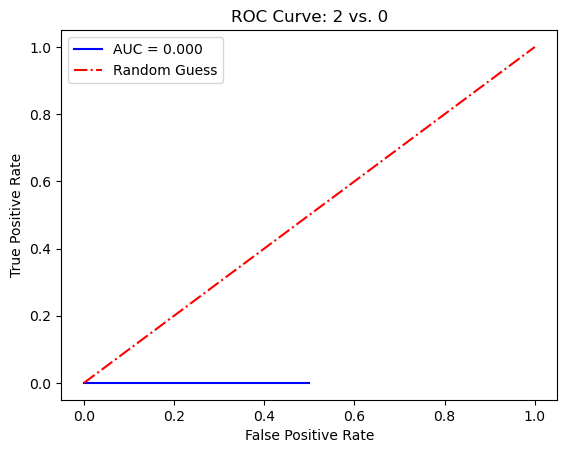

In [162]:
import pandas as pd

data = pd.read_csv("iris.csv").to_numpy()


# Get class labels
mapped, index, unique_arr = np.unique(data[:, -1], return_index=True, return_inverse=True)
data[:, -1] = unique_arr
iris_setosa, iris_versicolor, iris_virginica = np.split(data, index[1:])
labels_info = [[numb, name] for numb, name in enumerate(mapped)]
class_labels = [label[0] for label in labels_info]
print(labels_info)
print(class_labels)

filtered_data = data[data[:, -1] != 1]
prediction_class =['2', '0']
#true_labels,Y_predicted = naive_bayes_classification(data_B,prediction_class)
#plot_roc_curve(true_labels, Y_predicted, 'Iris-versicolor', 'Iris-virginica')

# Split into train and test data
train_data, test_data = train_test_split(filtered_data)
train_features, train_labels = class_split(train_data)

# Calculate feature statistics
feature_stats = calculate_feature_statistics(train_features, train_labels)

# Predict for a single test sample
predictions = []
true_labels = []

for test_sample in test_data:
    probabilities = naive_bayes_prediction(feature_stats, test_sample[:-1])
    predicted_class = probabilities_to_prediction(probabilities)
    predictions.append(predicted_class)
    true_labels.append(test_sample[-1])


# Calculate accuracy
accuracy = sum(p == t for p, t in zip(predictions, true_labels)) / len(true_labels)
print(f"True labels: {true_labels}")
print(f"Predictions: {predictions}")
print(f"Accuracy: {accuracy * 100:.2f}%")


target = filtered_data[:, -1]
data = filtered_data[:, :-1] 


# Evaluate using ROC
cross_validation(data, target, folds=10, threshold_stepsize=0.1)
